In [1]:
# install open-source ray if you haven't already
# !pip install "ray[default] installs the latest version; otherwise use a specific version
# !pip install "ray[default]==1.8.0"

In [2]:
###########
# Import libraries
###########

# Open-source libraries
import time               # Python time functions
import ray                # Run distributed code
import numpy as np        # Numerical processing
import pandas as pd       # Dataframe (tabular data) processing
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Open-source ARIMA forecasting libraries
import warnings
warnings.filterwarnings('ignore')
arima_model_type = "pmdarima.arima.arima.ARIMA"
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Open-source Prophet forecasting libraries
# Note: using kats since it looks more actively maintained than original prophet
import kats
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

!python --version
print(f"ray: {ray.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {mpl.__version__}")
print(f"pmdarima: {pm.__version__}")

Python 3.8.12
ray: 1.8.0
numpy: 1.20.3
pandas: 1.3.4
matplotlib: 3.4.3
pmdarima: 1.8.3


In [3]:
###########
# start-up ray on your laptop for testing purposes
###########

NUM_CPU = 8
ray.shutdown()  #in case a different ray server is already running

ray.init(
    # prevent errors in case re-running notebook
    ignore_reinit_error=True
    , num_cpus = NUM_CPU
)

2021-11-16 22:38:19,995	INFO services.py:1270 -- View the Ray dashboard at http://127.0.0.1:8268


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:18287',
 'object_store_address': '/tmp/ray/session_2021-11-16_22-38-18_928273_92479/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-16_22-38-18_928273_92479/sockets/raylet',
 'webui_url': '127.0.0.1:8268',
 'session_dir': '/tmp/ray/session_2021-11-16_22-38-18_928273_92479',
 'metrics_export_port': 54273,
 'node_id': 'cc70efc197425e0cb86cc2be6d268f0bc323af8817546166e4b7132f'}

# Read 8 months clean NYC taxi data 
Normally there is a data cleaning/prep step here to convert raw data -> cleaned data.  We'll dig into details of ETL later.  For now, let's just start with cleaned data...

In [4]:
###########
# Read pandas dataframe
###########
# read 8 months of clean, aggregated monthly taxi data
filename = "data/clean_taxi_monthly.parquet"
g_month = pd.read_parquet(filename) 

# rename "time" column, since prophet expects that, arima doesn't care
g_month.reset_index(inplace=True)
g_month.rename(columns={'pickup_monthly':'time'}, inplace=True)

display(g_month.head())

# Train a model per item_id
item_list = list(g_month['pulocationid'].unique())


,time,pulocationid,trip_quantity,pickup_lat,pickup_lon
0,2019-07-31,1,50,40.689514,-74.176788
1,2019-07-31,10,2201,40.678123,-73.791664
2,2019-07-31,100,138614,40.753513,-73.988785
3,2019-07-31,101,63,40.743721,-73.709068
4,2019-07-31,102,97,40.702679,-73.881996


In [15]:
###########
# Assume these are already-existing functions.
###########

###########
# Define an ARIMA train_model function, default train on 6 months, inference 2
###########
@ray.remote(num_returns=3)
def train_model_ARIMA_remote(theDF:pd.DataFrame
                , item_col:str
                , item_value:str, target_col:str
                , train_size:int=6) -> list:
    
    import warnings
    warnings.filterwarnings('ignore')

    # split data into train/test
    train, test = train_test_split(theDF.loc[(theDF[item_col]==item_value), :], train_size=train_size)
    
    # train and fit auto.arima model
    model = pm.auto_arima(y=train[target_col]
                          ,X=train.loc[:, (train.columns!=target_col) 
                                          & (train.columns!=item_col)]
                         )
    
    # here is the extra pickle step only required for statsmodels objects
    # Explanation why https://alkaline-ml.com/pmdarima/1.0.0/serialization.html
    return [train, test, pickle.dumps(model)]


###########
# Define ARIMA inference_model function
###########
@ray.remote
def inference_model_ARIMA_remote(model_pickle:bytes, test:pd.DataFrame
                    , item_col:str, target_col:str) -> pd.DataFrame:

    # Here is extra unpickle step
    model = pickle.loads(model_pickle)
    
    # ARIMA inference on test data
    forecast = pd.DataFrame(model.predict(n_periods=test.shape[0]
                         , X=test.loc[:, (test.columns!=target_col) & (test.columns!=item_col)]
                         , index=test.index))
    
    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.columns = ['fcst_arima']
    forecast.fcst_arima = forecast.fcst_arima.astype(np.int32)   
    forecast = pd.concat([forecast
                         , test.loc[:, target_col].reset_index()]
                         , axis=1)
    forecast.set_index('time', inplace=True)
    
    return forecast


###########
# Prophet train_model function, default train on 6 months, inference 2
###########
def train_model_PROPHET(theDF:pd.DataFrame
                , item_col:str
                , item_value:str, target_col:str
                , train_size:int=6) -> list:
    
    import warnings
    warnings.filterwarnings('ignore')

    # split data into train/test
    train, test = train_test_split(theDF.loc[(theDF[item_col]==item_value), :], train_size=train_size)
    
    # convert pandas df to TimeSeriesData(df), with "time" column and any number of value columns.
    train_ts = TimeSeriesData(train[["time", target_col]])
    test_ts = TimeSeriesData(test[["time", target_col]])
    
    # create a prophet model param instance
    params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

    # create a prophet model instance
    model = ProphetModel(train_ts, params)
    
    # fit model simply by calling m.fit()
    model.fit()

    # index train, test by time
    train.set_index('time', inplace=True)
    test.set_index('time', inplace=True)
    return [train, test, model]


###########
# Prophet inference_model function
###########
def inference_model_PROPHET(model:'kats.models.prophet.ProphetModel'
                            , test:pd.DataFrame
                            , item_col:str
                            , target_col:str) -> pd.DataFrame:
    
    import warnings
    warnings.filterwarnings('ignore')
    
    # Prophet inference on test data
    forecast = model.predict(steps=test.shape[0], freq="MS")

    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.fcst = forecast.fcst.astype(np.int32)
    forecast.fcst_lower = forecast.fcst_lower.astype(np.int32)
    forecast.fcst_upper = forecast.fcst_upper.astype(np.int32)
    forecast.columns = ['time', 'fcst_prophet', 'fcst_prophet_lower', 'fcst_prophet_upper']
    forecast = pd.concat([forecast
                         , test.loc[:, target_col].reset_index(drop=True)]
                         , axis=1)
    forecast.set_index('time', inplace=True)
    
    return forecast

In [ ]:
###########
# Main Ray distributed program flow to train and inference ARIMA and Prophet models
###########
# TODO:  Figure out how to suppress Prophet training messages?

# Convert your previously-defined regular python functions to ray parallelized functions
train_model_PROPHET_remote = ray.remote(train_model_PROPHET).options(num_returns=3)
inference_model_PROPHET_remote = ray.remote(inference_model_PROPHET)

# Define which algorithms you want to run
ALGORITHMS = ["ARIMA", "PROPHET"]


for algo_name in ALGORITHMS:
    print(f"algo: {algo_name}")
    train_obj_refs = []
    test_obj_refs = []
    model_obj_refs = []
    forecast_obj_refs = []
    
    # HANDLE ARIMA
    start = time.time()
    if algo_name == "ARIMA":
        # Train every model
        train_obj_refs, test_obj_refs, model_obj_refs = map(list, zip(*(
            [train_model_ARIMA_remote.remote(g_month.set_index('time')
                              , item_col='pulocationid'
                              , item_value=v
                              , target_col='trip_quantity'
                              , train_size=6) for p,v in enumerate(item_list)]
                              )))

        # Inference every model
        forecast_obj_refs = [inference_model_ARIMA_remote.remote(model_obj_refs[p]
                                , test_obj_refs[p]
                                , item_col='pulocationid'
                                , target_col='trip_quantity') 
                             for p in range(len(item_list))]


        # ray blocking step, to get the forecasts
        # ray.get() means block until all objectIDs requested are available
        forecast_ARIMA = ray.get(forecast_obj_refs)
        time_ARIMA = time.time()-start
        print(f"Done! Training and forecasting ARIMA on Ray finished in {time_ARIMA} seconds")


    # HANDLE PROPHET 
    start = time.time()
    if algo_name == "PROPHET":
        # Train every model
        train_obj_refs, test_obj_refs, model_obj_refs = map(list, zip(*(
                [train_model_PROPHET_remote.remote(g_month
                                  , item_col='pulocationid'
                                  , item_value=v
                                  , target_col='trip_quantity'
                                  , train_size=6) for p,v in enumerate(item_list)]
                                  )))

        # Inference every model
        forecast_obj_refs = [inference_model_PROPHET_remote.remote(model_obj_refs[p]
                                , test_obj_refs[p]
                                , item_col='pulocationid'
                                , target_col='trip_quantity') 
                             for p in range(len(item_list))]


        # ray blocking step, to get the forecasts
        # ray.get() means block until all objectIDs requested are available
        forecast_PROPHET = ray.get(forecast_obj_refs)
        time_PROPHET = time.time()-start
        print(f"Done! Training and forecasting Prophet on Ray finished in {time_PROPHET} seconds")

# Rough checking

In [20]:
print(f"Done! Training and forecasting ARIMA on Ray finished in {time_ARIMA} seconds")
print(f"Done! Training and forecasting Prophet on Ray finished in {time_PROPHET} seconds")

Done! Training and forecasting ARIMA on Ray finished in 1.228780746459961 seconds
Done! Training and forecasting Prophet on Ray finished in 60.78129196166992 seconds


In [21]:
###########
# Assemble all the forecasts in one big df, for easier model comparison
###########

forecasts = []
for p,v in enumerate(item_list[0:2]):
    # assemble arima forecasts, add item_id back in
    temp_arima = forecast_ARIMA[p] \
        .reset_index() \
        .copy()
    temp_arima['pulocationid'] = v
    temp_arima = temp_arima.reindex(['time', 'pulocationid', 'trip_quantity', 'fcst_arima'], axis=1)
    
    # assemble prophet forecasts
    temp_prophet = forecast_PROPHET[p] \
        .reset_index() \
        .drop(["time", "trip_quantity"], axis=1) \
        .copy()
    temp = pd.merge(temp_arima, temp_prophet, left_index=True, right_index=True)
    forecasts.append(temp)

    
# print(forecasts)
forecasts = pd.DataFrame(np.concatenate(forecasts))
forecasts.columns=['time', 'pulocationid', 'trip_quantity', 'fcst_arima'
                             , 'fcst_prophet', 'fcst_prophet_lower'
                             , 'fcst_prophet_upper']
forecasts

,time,pulocationid,trip_quantity,fcst_arima,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper
0,2020-01-31,1,34,49,49,44,53
1,2020-02-29,1,35,49,49,44,54
2,2020-01-31,10,1689,2003,1859,1727,1989
3,2020-02-29,10,1386,2003,1801,1675,1921


len(forecast): 4


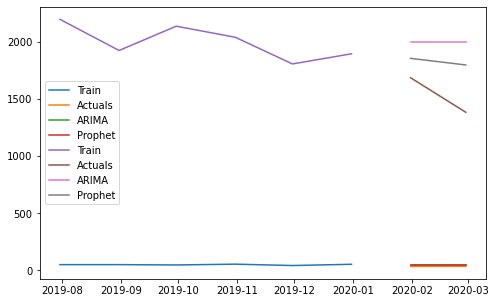

In [22]:
###########
# inspect a few forecasts
###########

# assert len(forecasts) == len(item_list)
print(f"len(forecast): {len(forecasts)}")

# ray.get the model artifacts, in case you want to check them
train = ray.get(train_obj_refs)
test = ray.get(test_obj_refs)

# eyeball first two forecasts
plt.figure(figsize=(8,5))
for p,v in enumerate(item_list[0:2]):
    item_forecast = forecasts.loc[(forecasts.pulocationid==v), :].copy()
    item_forecast.set_index("time", inplace=True)
    # display(item_forecast)    
    
    plt.plot(train[p]['trip_quantity'], label="Train")
    plt.plot(test[p]['trip_quantity'], label="Actuals")
    plt.plot(item_forecast["fcst_arima"], label="ARIMA")
    plt.plot(item_forecast["fcst_prophet"], label="Prophet")
    
    plt.legend(loc='best')

Forecast for item 1:


,pulocationid,trip_quantity,fcst_arima,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper
time,,,,,,
2020-01-31,1,34,49,49,44,53
2020-02-29,1,35,49,49,44,54


Forecast for item 10:


,pulocationid,trip_quantity,fcst_arima,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper
time,,,,,,
2020-01-31,10,1689,2003,1859,1727,1989
2020-02-29,10,1386,2003,1801,1675,1921


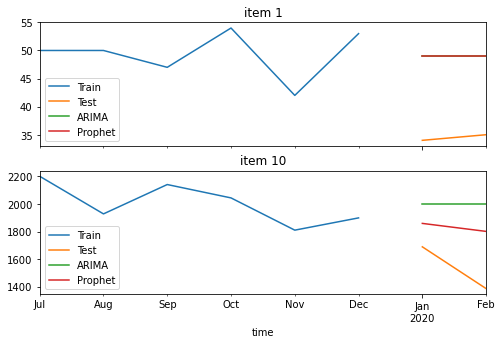

In [23]:
# fancier plots
## inspect your forecasts

# just first two in the list
fig, axs = plt.subplots(2, 1, figsize=(8,5), sharex=True)
for p,v in enumerate(item_list[0:2]):  
    print(f"Forecast for item {v}:")
    item_forecast = forecasts.loc[(forecasts.pulocationid==v), :].copy()
    item_forecast.set_index("time", inplace=True)
    display(item_forecast)
    
    ax = axs[p]
    train[p].trip_quantity.plot(ax=ax, label="Train")
    test[p].trip_quantity.plot(ax=ax, label="Test")
    # item_forecast.predicted_value.plot(ax=ax, label="Forecast")
    item_forecast["fcst_arima"].plot(ax=ax, label="ARIMA")
    item_forecast["fcst_prophet"].plot(ax=ax, label="Prophet")
    ax.legend(loc='best')
    ax.set_title( f"item {v}" )